In [110]:
%load_ext autoreload
%autoreload 2

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm

# load dataset 
import dataset_rs
import utils_rs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
'''
class Seg_RS_dataset():
    def __init__(self, img_dir,mask_dir, phase):
        self.phase = phase

        self.image_files = sorted(glob( os.path.join( img_dir , "*.png")) )
        self.mask_files  = sorted(glob( os.path.join( mask_dir , "*.png")))
'''

img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

# dataset = dataset_rs.Seg_RS_dataset(img_path, mask_path, 224, "train")
#img_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Kaggle_Massachusetts/png/train"
#mask_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Kaggle_Massachusetts/png/train_labels"
dataset = dataset_rs.Seg_RS_dataset(img_dir=img_path, mask_dir=mask_path, image_resize = None, phase="train" )


In [112]:
img,label = dataset.__getitem__(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


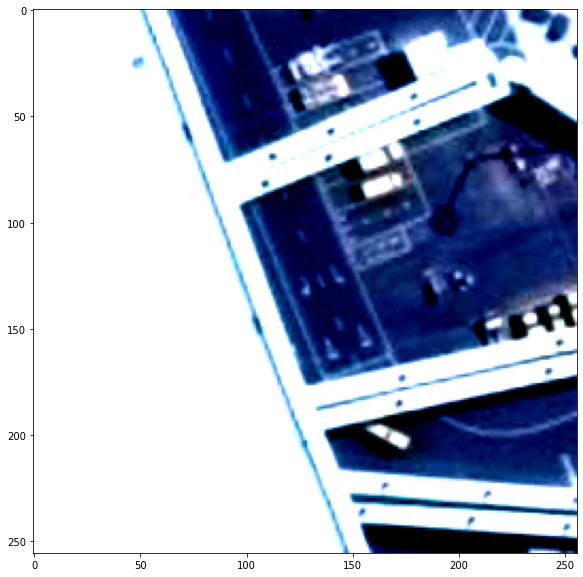

In [113]:
utils_rs.torch_display(img)

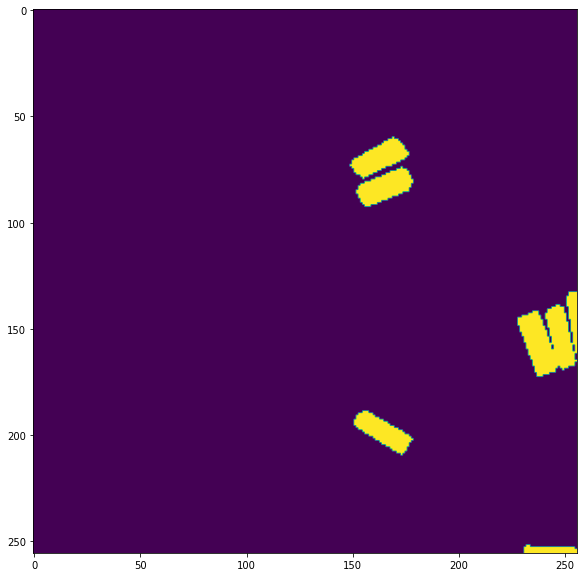

In [114]:
label_ = label.unsqueeze(-1)
plt.figure(figsize=(10,10))
plt.imshow(label_)

In [117]:
model = smp.UnetPlusPlus(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [119]:
tgt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/02.ckpts"
ckpt_path = os.path.join( tgt_path, sorted(os.listdir(tgt_path))[-1]  )
print(ckpt_path)

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/02.ckpts/ver_95_bulding_epoch_183.pt


In [121]:
sorted(os.listdir(tgt_path))

['model_1.pt',
 'model_2.pt',
 'model_3.pt',
 'model_ver_5_1.pt',
 'model_ver_5_2.pt',
 'model_ver_5_3.pt',
 'model_ver_5_4.pt',
 'ver_101_bulding_epoch_1.pt',
 'ver_101_bulding_epoch_2.pt',
 'ver_101_bulding_epoch_3.pt',
 'ver_101_bulding_epoch_4.pt',
 'ver_101_bulding_epoch_5.pt',
 'ver_101_bulding_epoch_6.pt',
 'ver_101_bulding_epoch_7.pt',
 'ver_89_epoch_1.pt',
 'ver_89_epoch_45.pt',
 'ver_95_bulding_epoch_183.pt']

In [116]:
tgt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/02.ckpts"
ckpt_path = os.path.join( tgt_path, sorted(os.listdir(tgt_path))[-1]  )
print(ckpt_path)


device = "cpu"

checkpoint = torch.load(ckpt_path, map_location=device)
#model = UNet(num_classes=num_classes)
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/02.ckpts/ver_95_bulding_epoch_183.pt


RuntimeError: Error(s) in loading state_dict for UnetPlusPlus:
	size mismatch for segmentation_head.0.weight: copying a param with shape torch.Size([2, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for segmentation_head.0.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([16]).

In [ ]:
img_ = img.unsqueeze(0)
pred = model(img_)
#pred_ = pred.unsqueeze(0)
print(pred.shape)
pred_mask = torch.argmax(pred, dim=1)
print(pred1_mask.shape)

torch.Size([1, 2, 256, 256])
torch.Size([1, 256, 256])


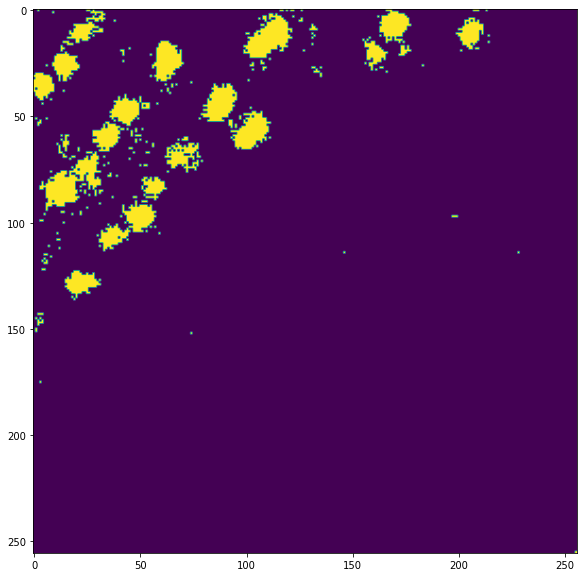

In [ ]:
utils_rs.torch_display(pred_mask)

In [ ]:
pred.shape

torch.Size([1, 2, 256, 256])

In [ ]:
pred_ = pred.squeeze(0)
pred_mask = torch.argmax(pred_, dim=0)

In [ ]:
pred_mask.shape

torch.Size([256, 256])

In [ ]:
torch.unique(pred_mask)

tensor([0, 1])

In [ ]:
pred_mask_a = pred_mask.unsqueeze(0)

In [ ]:
pred_mask_a.shape

torch.Size([1, 256, 256])

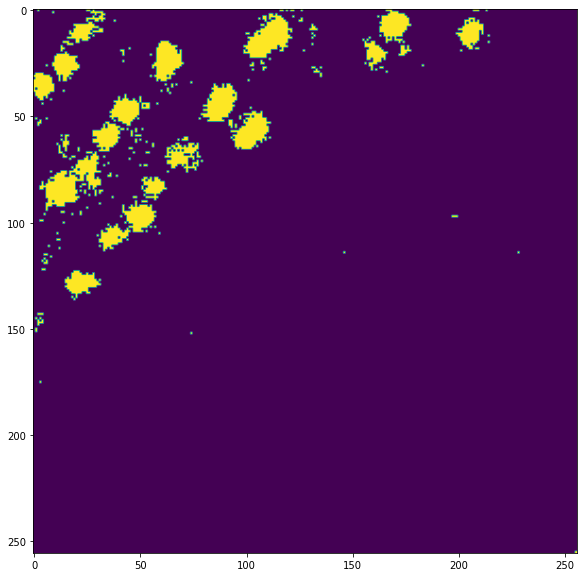

In [ ]:
utils_rs.torch_display(pred_mask_a)

In [ ]:
@torch.no_grad()
def predict_segment_smp(image, model, num_classes, device):
    PIL_image = Image.fromarray(image)
    tensor_image = transformer(PIL_image)
    tensor_image = tensor_image.to(device)

    model.eval()
    pred_mask = model(torch.unsqueeze(tensor_image, dim=0))
    #pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0)
    #pred_mask = pred_mask.numpy()
    #rgb_mask = decode_seg_map(pred_mask, num_classes)
    return pred_mask